# PCA on neuronal features made of tuning indices

In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.12.1+cu102
Using device: cuda:0


## Loading tuning curve data

In [2]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

In [3]:
def tuning_index(hd_stat):
    """Compute the tuning index of a tuning curve with a given statistics of spike count distributions."""
    tc_max = np.max(hd_stat, axis=-1)
    tc_min = np.min(hd_stat, axis=-1)

    return (tc_max - tc_min) / (tc_max + tc_min)

In [4]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'

phase='wake'

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129']
} 

subset='hdc'
mouse_id = 'Mouse24'
session_id = '131213'

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, 6))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, 6))
for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(datadir, mouse_id, session_id, subset)
            ti_rates = tuning_index(tc_rates)  # (neurons, num_cov)
            ti_FF = tuning_index(tc_FF)
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = ti_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = ti_rates.shape[0]
                
            features_rates = np.concatenate((features_rates, ti_rates), axis=0)
            features_FF = np.concatenate((features_FF, ti_FF), axis=0)


# 1. PCA on rate features

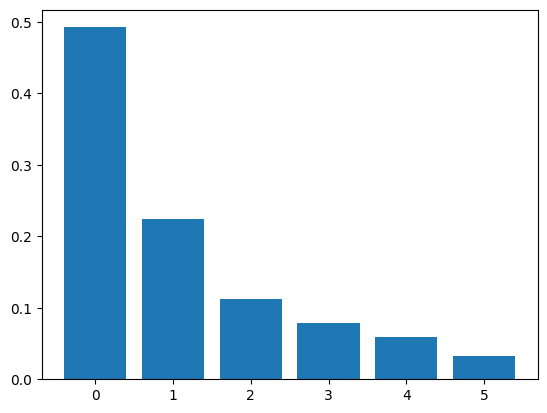

In [5]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(features_rates)
var_explained = pca.explained_variance_ratio_

plt.bar(np.arange(len(var_explained)), var_explained)

components = pca.transform(features_rates)


In [10]:
def plot_pca(components, labels, label_names, plot3d=False, ax=None, colors=None):
    
    sorted_indices = np.argsort(labels)
    sorted_components = components[sorted_indices]
    
    num_neurons_per_label = []
    for i, name in enumerate(label_names):
        num_neurons_per_label.append(np.where(labels==i)[0].size)
    print(num_neurons_per_label)
    cum_neurons = np.cumsum(np.array(num_neurons_per_label))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    # define the colormap
    if colors is None:
        colors = list(matplotlib.colors.BASE_COLORS)

    if ax is None:
        if plot3d:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
        else:
            _, ax = plt.subplots()
    if not plot3d:
        for i, label in enumerate(label_names):
                ax.scatter(sorted_components[cum_neurons[i]:cum_neurons[i+1], 0], sorted_components[cum_neurons[i]:cum_neurons[i+1], 1], c=colors[i], label=label)
        ax.set_title('First 2 principal components of neuronal features')
    else:
        for i, label in enumerate(label_names):
                ax.scatter(sorted_components[cum_neurons[i]:cum_neurons[i+1], 0], sorted_components[cum_neurons[i]:cum_neurons[i+1], 1], sorted_components[cum_neurons[i]:cum_neurons[i+1], 2], c=colors[i], label=label)
        ax.set_title('First 3 principal components of neuronal features')
    ax.legend()
    ax.grid()
    ax.set_xlabel('1st PC')
    ax.set_ylabel('2nd PC')
    if plot3d:
        ax.set_zlabel('3rd PC')

## 1.1. Plot hdc vs non-hdc

In [8]:
labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

[420, 112]
[420, 112]


Text(0.5, 0.92, 'Rate Tuning Indices analysis')

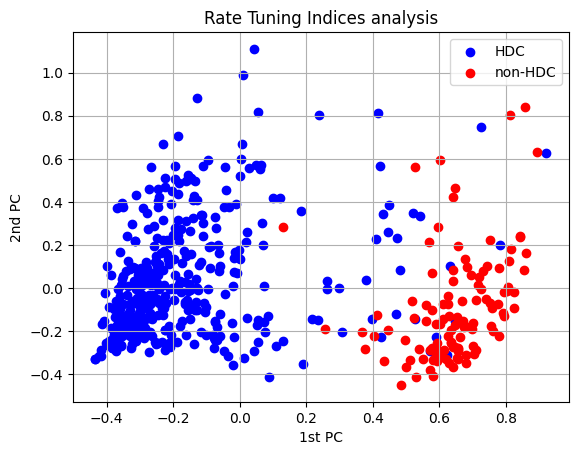

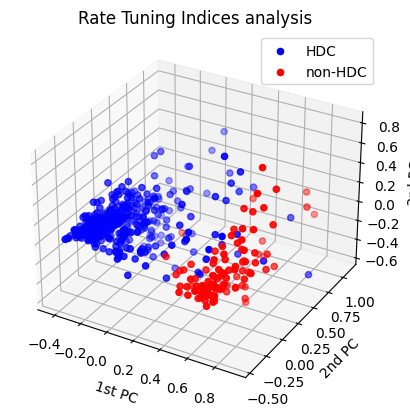

In [19]:
filter_hdc = np.array(labels_hdc).astype(bool)

plot_pca(components, filter_hdc, ['HDC', 'non-HDC'], colors=['b', 'r'])
plt.title('Rate Tuning Indices analysis')

plot_pca(components, filter_hdc, ['HDC', 'non-HDC'], plot3d=True, colors=['b', 'r'])
plt.title('Rate Tuning Indices analysis')

## 1.2. Plot neurons from different mice

In [16]:
labels_mice = []
label_names = []
for i, mouse_id in enumerate(mice_sessions.keys()):
    label_names.append(mouse_id)
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])

[85, 172, 63, 111, 101]


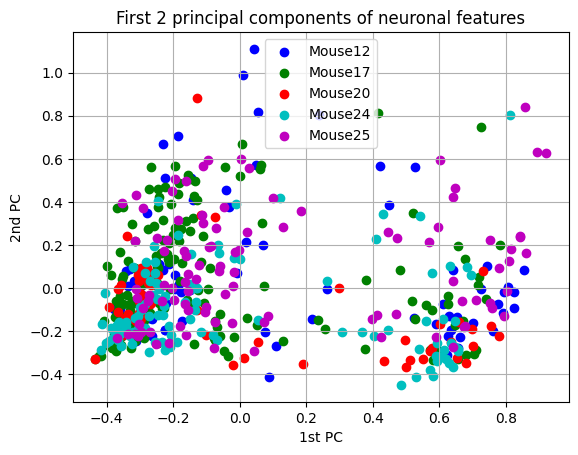

In [23]:
plot_pca(components, np.array(labels_mice), label_names)

# 2. PCA on Fano Factor features

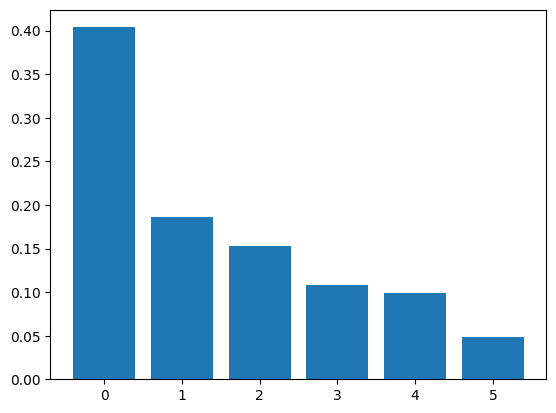

In [24]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(features_FF)
var_explained = pca.explained_variance_ratio_

plt.bar(np.arange(len(var_explained)), var_explained)


components = pca.fit_transform(features_FF)

[420, 112]
[420, 112]


Text(0.5, 0.92, 'Rate Tuning Indices analysis')

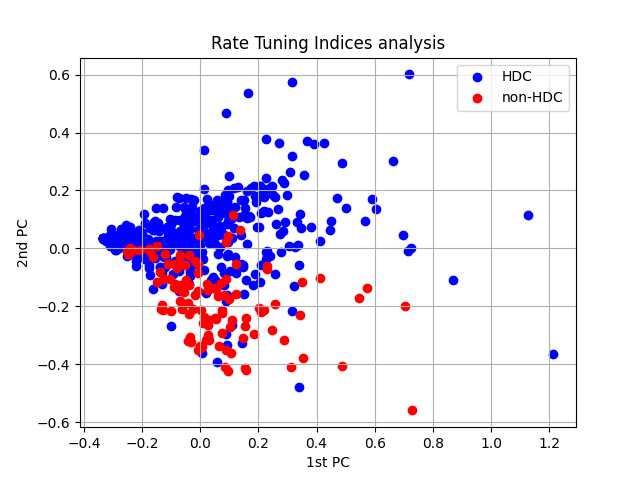

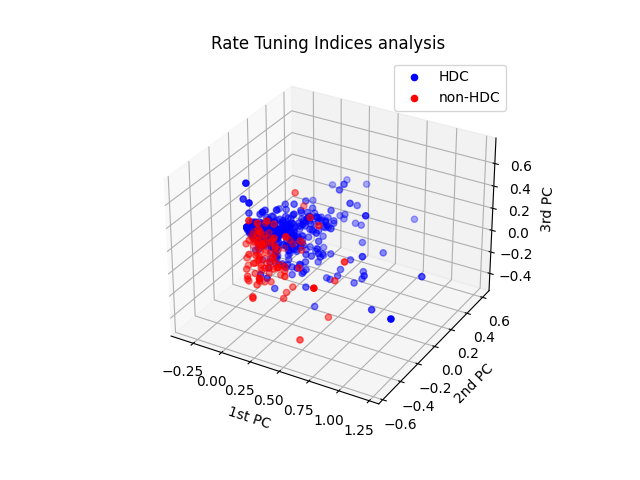

In [25]:
%matplotlib widget

filter_hdc = np.array(labels_hdc).astype(bool)

plot_pca(components, filter_hdc, ['HDC', 'non-HDC'], colors=['b', 'r'])
plt.title('Rate Tuning Indices analysis')

plot_pca(components, filter_hdc, ['HDC', 'non-HDC'], plot3d=True, colors=['b', 'r'])
plt.title('Rate Tuning Indices analysis')